**Alireza Kheirandish**

97101604

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone 'https://github.com/amnghd/Persian_poems_corpus.git'

fatal: destination path 'Persian_poems_corpus' already exists and is not an empty directory.


In [5]:
from transformers import BertModel, BertTokenizer, BertConfig

config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Part A & C:**

In [6]:
choosen_poets = ["anvari", "hafez", "asad", "asadi", "saadi", "moulavi", "vahshi", "attar", "amir", "sanaee"]
poets_len = len(choosen_poets)

In [7]:
def load_data(choosen_poets):
    beyts_all = []
    n_beyts = []
    for i, poet in enumerate(choosen_poets):
        file_name = poet + "_norm.txt"
        root = "/content/Persian_poems_corpus/normalized"
        path = os.path.join(root, file_name)
        with open(path, 'r') as f:
            txt = f.read().splitlines()[2:]
        beyts = [" ".join([x, y]) for x, y in zip(txt[0::2], txt[1::2])]
        n_beyts.append(len(beyts))
        beyts_all.append(beyts)
    return beyts_all, np.array(n_beyts)

In [8]:
X, n_beyts = load_data(choosen_poets)
min(n_beyts)

5113

In [9]:
(X[0][0])

'بیا ای جان بیا ای جان بیا فریاد رس ما را چو ما را یک نفس باشد نباشی یک نفس ما را'

In [10]:
X_final = []
y_final = []
for i, x in enumerate(X):
    idx = np.arange(n_beyts[i])
    np.random.shuffle(idx)
    x_temp = [x[j] for j in range(min(n_beyts))]
    X_final += x_temp
    y_final.append(i * np.ones(len(x_temp)))
y_final = np.concatenate(y_final)

In [11]:
class MyDataset(Dataset):
    def __init__(self, beyts, labels, tokenizer_):
        self.beyts = beyts
        self.labels = labels
        self.tokenizer_ = tokenizer_
    def __len__(self):
        return len(self.beyts)
    def __getitem__(self, item):
        beyt = self.beyts[item]
        label = self.labels[item]
        tokenized = self.tokenizer_.encode_plus(
            beyt,
            None,
            add_special_tokens=True,
            max_length= 50,
            padding='max_length',
            return_token_type_ids=True,
            return_tensors='pt'
        )
        tokenized['label'] = torch.LongTensor([int(label)])
        tokenized['input_ids'] = tokenized['input_ids'].flatten()
        tokenized['token_type_ids'] = tokenized['token_type_ids'].flatten()
        tokenized['attention_mask'] = tokenized['attention_mask'].flatten()
        return tokenized

In [12]:
data = MyDataset(X_final, y_final, tokenizer)


In [13]:
train_data, validation_data, test_data = random_split(data, [0.8, 0.12, 0.08])

In [14]:
language_model_frozen = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
temp = train_data[0]
temp = language_model_frozen(input_ids=torch.unsqueeze(temp['input_ids'], dim=0),
                                attention_mask=torch.unsqueeze(temp['attention_mask'], dim=0),
                                token_type_ids=torch.unsqueeze(temp['token_type_ids'], dim=0))['pooler_output']
last_layer_size = temp.shape[1]

In [16]:
# temp = train_data[0]
# torch.mean(torch.exp(language_model_frozen(input_ids=torch.unsqueeze(temp['input_ids'], dim=0),
#                                 attention_mask=torch.unsqueeze(temp['attention_mask'], dim=0),
#                                 token_type_ids=torch.unsqueeze(temp['token_type_ids'], dim=0))[0]))

In [17]:
BATCH_SIZE = 64
EPOCHS = 5

In [18]:
from tqdm import tqdm
class MyModel(nn.Module):
    def __init__(self, 
                 language_model,
                 classifier_model,
                 tuning_method,
                 optimizer="ADAM"
                 ):
        
        super(MyModel, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.lr = 1e-5
        self.language_model = language_model
        self.classifier_model = classifier_model
        # self.per = []
        if tuning_method == "fine-tune":
            params = list(self.classifier_model.parameters()) + list(self.language_model.parameters())
        else:
            params = self.classifier_model.parameters()

        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(params, lr=self.lr)
        else:
            self.optimizer = torch.optim.Adam(params, lr=self.lr)

    def forward(self, ids, types, mask):
        lan_out = self.language_model(
            input_ids=ids,
            attention_mask=mask,
            token_type_ids=types
        )
        loss_per = (torch.sum(torch.exp(lan_out[0])).to(device))
        # print(lan_out.keys())
        out = self.classifier_model(lan_out["pooler_output"])
        
        return [out,loss_per]

    @staticmethod 
    def calculate_accuracy(predicted, true_labels):
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()

    def evaluate(self, evaluation_data, batch_size, phase):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data,
                                       batch_size=batch_size,
                                       shuffle=True)
        loss = 0
        loss_per = 0
        accuracy = 0
        cm = np.zeros((poets_len, poets_len), dtype=int)
        for batch in evaluation_loader:
            with torch.no_grad():
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels_1 = batch["label"].flatten().to(device)
                # print((labels.shape))
                outputs, loss_ = self.forward(ids, types, mask)
                # print((outputs.shape))
                predicted = torch.argmax(outputs, dim=-1)
                # print((predicted.shape))
                loss += self.criterion(outputs, labels_1).item() * len(labels_1)
                t = self.calculate_accuracy(predicted, labels_1)
                accuracy += t * len(labels_1)
                loss_per = loss_ * len(labels_1)
                if phase == "test":
                    
                    cm += confusion_matrix(labels_1.cpu(), 
                                           predicted.cpu(),
                                           labels=[i for i in range(poets_len)])
        if phase == "test":
          print(loss_per/len(evaluation_data))
        loss_per/= len(evaluation_data)
        accuracy /= len(evaluation_data)
        loss /= len(evaluation_data)
        return accuracy, loss, cm, loss_per

    def fit(self, train_data, val_data, batch_size=64, n_epoch=12):

        train_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True)

        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
        self.loss_per = []

        self.train()
        for epoch in range(n_epoch):
            print(f"Epoch #{epoch+1}:")
            loss_per_e = 0
            for batch in tqdm(train_loader):
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["label"].flatten().to(device)

                output,loss_ = self.forward(ids, types, mask)
                self.optimizer.zero_grad()
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                loss_per_e += loss_

            train_acc_epoch, train_loss_epoch, train_cm, loss_per_e_train = self.evaluate(train_data, batch_size, "train")
            val_acc_epoch, val_loss_epoch, val_cm, loss_per_e_val = self.evaluate(val_data, batch_size, "validation")
            self.train_acc.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)
            self.val_acc.append(val_acc_epoch)
            self.val_loss.append(val_loss_epoch)
            self.loss_per.append(loss_per_e_train)

            print(f"train_acc={(train_acc_epoch*100):.2f}%, train_loss = {train_loss_epoch:.2f}")
            print(f"val_acc={(val_acc_epoch*100):.2f}%, val_loss = {val_loss_epoch:.2f}")
            print(f"Perplexity={(loss_per_e_train):.2f}")

In [24]:
from tqdm import tqdm
class MyModel_without_per(nn.Module):
    def __init__(self, 
                 language_model,
                 classifier_model,
                 tuning_method,
                 optimizer="ADAM",
                 lr = 1e-4):
        
        super(MyModel_without_per, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.language_model = language_model
        self.classifier_model = classifier_model
        # self.per = []
        if tuning_method == "fine-tune":
            params = list(self.classifier_model.parameters()) + list(self.language_model.parameters())
        else:
            params = self.classifier_model.parameters()

        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(params, lr=self.lr)
        else:
            self.optimizer = torch.optim.Adam(params, lr=self.lr)

    def forward(self, ids, types, mask):
        lan_out = self.language_model(
            input_ids=ids,
            attention_mask=mask,
            token_type_ids=types
        )
        # loss_per = (torch.sum(torch.exp(lan_out[0])).to(device))
        # print(lan_out.keys())
        out = self.classifier_model(lan_out["pooler_output"])
        
        return out

    @staticmethod 
    def calculate_accuracy(predicted, true_labels):
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()

    def evaluate(self, evaluation_data, batch_size, phase):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data,
                                       batch_size=batch_size,
                                       shuffle=True)
        loss = 0
        # loss_per = 0
        accuracy = 0
        cm = np.zeros((poets_len, poets_len), dtype=int)
        for batch in evaluation_loader:
            with torch.no_grad():
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels_1 = batch["label"].flatten().to(device)
                # print((labels.shape))
                outputs = self.forward(ids, types, mask)
                # print((outputs.shape))
                predicted = torch.argmax(outputs, dim=-1)
                # print((predicted.shape))
                loss += self.criterion(outputs, labels_1).item() * len(labels_1)
                t = self.calculate_accuracy(predicted, labels_1)
                accuracy += t * len(labels_1)
                # loss_per = loss_ * len(labels_1)
                if phase == "test":
                    
                    cm += confusion_matrix(labels_1.cpu(), 
                                           predicted.cpu(),
                                           labels=[i for i in range(poets_len)])
        # if phase == "test":
        #   print(loss_per/len(evaluation_data))
        # loss_per/= len(evaluation_data)
        accuracy /= len(evaluation_data)
        loss /= len(evaluation_data)
        return accuracy, loss, cm

    def fit(self, train_data, val_data, batch_size=64, n_epoch=12):

        train_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True)

        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
        # self.loss_per = []

        self.train()
        for epoch in range(n_epoch):
            print(f"Epoch #{epoch+1}:")
            loss_per_e = 0
            for batch in tqdm(train_loader):
                ids = batch["input_ids"].to(device)
                types = batch["token_type_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["label"].flatten().to(device)

                output = self.forward(ids, types, mask)
                self.optimizer.zero_grad()
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                # loss_per_e += loss_

            train_acc_epoch, train_loss_epoch, train_cm = self.evaluate(train_data, batch_size, "train")
            val_acc_epoch, val_loss_epoch, val_cm = self.evaluate(val_data, batch_size, "validation")
            self.train_acc.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)
            self.val_acc.append(val_acc_epoch)
            self.val_loss.append(val_loss_epoch)
            # self.loss_per.append(loss_per_e_train)

            print(f"train_acc={(train_acc_epoch*100):.2f}%, train_loss = {train_loss_epoch:.2f}")
            print(f"val_acc={(val_acc_epoch*100):.2f}%, val_loss = {val_loss_epoch:.2f}")
            # print(f"Perplexity={(loss_per_e_train):.2f}")

In [25]:
simple_linear_model = nn.Sequential(*[
                            nn.Flatten(),
                            nn.Linear(last_layer_size, poets_len)
                            ])
my_model_1 = MyModel(language_model_frozen,
                            classifier_model = simple_linear_model,
                            tuning_method = "linear_tune",
                            optimizer="ADAM").to(device)
my_model_1_faster = MyModel_without_per(language_model_frozen,
                            classifier_model = simple_linear_model,
                            tuning_method = "linear_tune",
                            optimizer="ADAM").to(device)

In [26]:
my_model_1_faster.fit(train_data,
                        validation_data,
                        batch_size=BATCH_SIZE,
                        n_epoch=EPOCHS)

Epoch #1:


100%|██████████| 640/640 [05:25<00:00,  1.97it/s]


train_acc=24.40%, train_loss = 2.16
val_acc=25.25%, val_loss = 2.16
Epoch #2:


100%|██████████| 640/640 [05:22<00:00,  1.98it/s]


train_acc=28.10%, train_loss = 2.07
val_acc=28.56%, val_loss = 2.07
Epoch #3:


100%|██████████| 640/640 [05:22<00:00,  1.98it/s]


train_acc=29.57%, train_loss = 2.02
val_acc=29.91%, val_loss = 2.01
Epoch #4:


 11%|█         | 69/640 [00:35<04:50,  1.96it/s]


KeyboardInterrupt: ignored

In [20]:
my_model_1.fit(train_data,
                        validation_data,
                        batch_size=BATCH_SIZE,
                        n_epoch=EPOCHS)

Epoch #1:


100%|██████████| 640/640 [05:30<00:00,  1.94it/s]


train_acc=31.53%, train_loss = 1.92
val_acc=30.66%, val_loss = 1.94
Perplexity=133.54
Epoch #2:


100%|██████████| 640/640 [05:26<00:00,  1.96it/s]


train_acc=34.84%, train_loss = 1.84
val_acc=33.35%, val_loss = 1.86
Perplexity=138.72
Epoch #3:


100%|██████████| 640/640 [05:23<00:00,  1.98it/s]


train_acc=37.49%, train_loss = 1.79
val_acc=35.31%, val_loss = 1.82
Perplexity=148.02
Epoch #4:


100%|██████████| 640/640 [05:23<00:00,  1.98it/s]


train_acc=36.86%, train_loss = 1.77
val_acc=35.03%, val_loss = 1.81
Perplexity=134.62
Epoch #5:


100%|██████████| 640/640 [05:24<00:00,  1.97it/s]


train_acc=38.80%, train_loss = 1.74
val_acc=36.59%, val_loss = 1.78
Perplexity=146.59


In [28]:
def f1_calculator(cm):
    TP = np.diag(cm)
    all_true = np.sum(TP)
    FP = np.sum(np.sum(cm, axis=0) - TP)
    FN = np.sum(np.sum(cm, axis=1) - TP)
    precision = all_true / (all_true + FP)
    recall = all_true / (all_true + FN)
    f1 = 2 * recall * precision / (recall + precision)
    return f1

In [30]:
# if model is without peripex then delete the fourth output(_)
# accuracy, loss, cm,_ = my_model_1.evaluate(test_data, BATCH_SIZE, "test")
accuracy, loss, cm= my_model_1_faster.evaluate(test_data, BATCH_SIZE, "test")

f1 = f1_calculator(cm)
print("Part A Test Results:")
print(f"Accuracy: {100 * accuracy:.2f}% , F1: {f1:.2f}, Loss: {loss:.2f}")

Part A Test Results:
Accuracy: 27.95% , F1: 0.28, Loss: 2.03


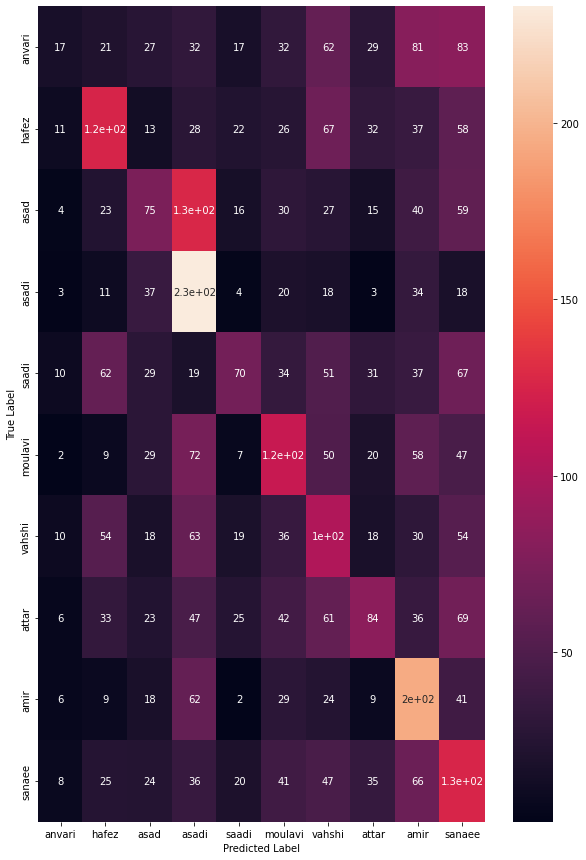

In [31]:
def plot_conf_mat(cm):
        fig = plt.figure(figsize=(10, 15))
        df_cm = pd.DataFrame(cm, index = [i for i in choosen_poets],
                      columns = [i for i in choosen_poets])
        sns.heatmap(df_cm, annot=True)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
        return 
plot_conf_mat(cm)

In [32]:
language_model_trainable = BertModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in language_model_trainable.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Part B:**

In [34]:
BATCH_SIZE = 32
EPOCHS = 5
optimizer_mode ="ADAM"
simple_linear_model_fine_tune = nn.Sequential(*[
                            nn.Flatten(),
                            nn.Linear(last_layer_size, poets_len)
                            ])
my_model_fine_tune = MyModel_without_per(language_model_trainable,
                                    classifier_model = simple_linear_model_fine_tune,
                                    tuning_method ="fine-tune",
                                    optimizer=optimizer_mode
                                    ).to(device)

In [35]:
my_model_fine_tune.fit(train_data,
                              validation_data,
                              batch_size=BATCH_SIZE,
                              n_epoch=EPOCHS)

Epoch #1:


100%|██████████| 1279/1279 [06:21<00:00,  3.36it/s]


train_acc=74.20%, train_loss = 0.76
val_acc=63.08%, val_loss = 1.06
Epoch #2:


  8%|▊         | 107/1279 [00:31<05:46,  3.38it/s]


KeyboardInterrupt: ignored

In [36]:
# accuracy, loss, cm,_ = my_model_fine_tune.evaluate(test_data, BATCH_SIZE, "test")
accuracy, loss, cm = my_model_fine_tune.evaluate(test_data, BATCH_SIZE, "test")
f1 = f1_calculator(cm)
print("Part B Test Results"+" "+ optimizer_mode+ ":")
print(f"Accuracy: {100 * accuracy:.2f}% , F1: {f1:.2f}, Loss: {loss:.2f}")

Part B Test Results ADAM:
Accuracy: 63.42% , F1: 0.63, Loss: 1.15


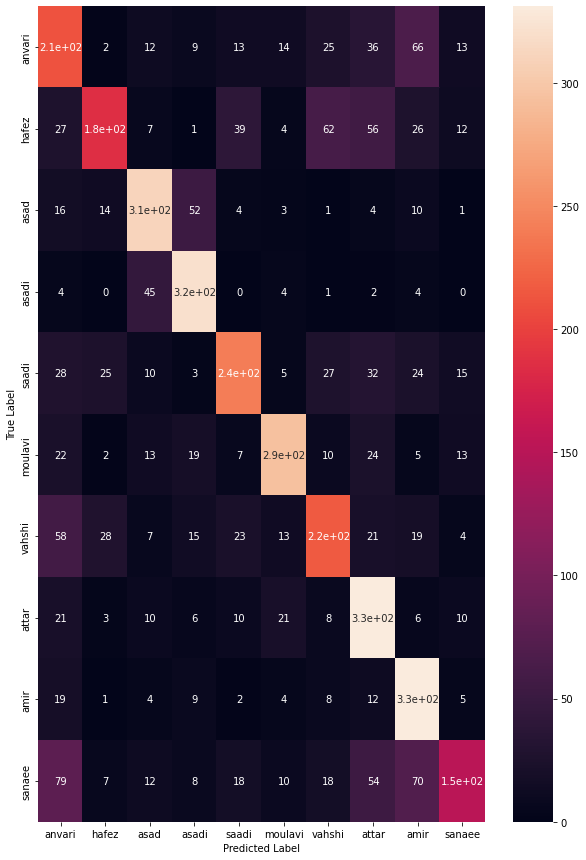

In [37]:
plot_conf_mat(cm)

**Important Note:**

If you want to change the optimizer just change the optimizer option in the model!

If you want to see the perplexity change the model with the per. In this regard, you need to increase the output of the evaluation because it need 4 argument.

**Example:**

In [38]:
BATCH_SIZE = 32
EPOCHS = 5
optimizer_mode ="SGD"
simple_linear_model_fine_tune = nn.Sequential(*[
                            nn.Flatten(),
                            nn.Linear(last_layer_size, poets_len)
                            ])
my_model_fine_tune = MyModel_without_per(language_model_trainable,
                                    classifier_model = simple_linear_model_fine_tune,
                                    tuning_method ="fine-tune",
                                    optimizer=optimizer_mode
                                    ).to(device)

In [39]:
my_model_fine_tune.fit(train_data,
                              validation_data,
                              batch_size=BATCH_SIZE,
                              n_epoch=EPOCHS)

Epoch #1:


100%|██████████| 1279/1279 [05:23<00:00,  3.95it/s]


train_acc=75.80%, train_loss = 1.13
val_acc=63.90%, val_loss = 1.32
Epoch #2:


  6%|▌         | 75/1279 [00:19<05:06,  3.93it/s]


KeyboardInterrupt: ignored